In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
import pickle

Using TensorFlow backend.
c:\users\badri\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\badri\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\badri\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
train_df = pd.read_csv("drugsComTrain_raw.csv", sep=',')
test_df = pd.read_csv("drugsComTest_raw.csv", sep=',')

In [4]:
print("Train shape :" ,train_df.shape)
print("Test shape :", test_df.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


In [5]:
# Missing Values Removal

train_df = train_df.dropna(axis=0)
test_df = test_df.dropna(axis=0)

In [6]:
#Preprocessing
#Preprocessing is relatively simple, we create a tokenizer and then we tokenize the reviews in both dataframes. After that create variables train_data and test_data that contain the padded sequences obtained from the tokenizer with max length value set to 200.
# Use a tokenizer to assign token values to words in the user reviews

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['review'])
pickle.dump(tokenizer, open("tokenizer.pickle", "wb"))

train_sequences = tokenizer.texts_to_sequences(train_df['review'])
test_sequences = tokenizer.texts_to_sequences(test_df['review'])

max_len = 100
train_data = pad_sequences(train_sequences, maxlen=max_len)
test_data = pad_sequences(test_sequences, maxlen=max_len)



In [7]:
# Convert rating labels to three classes (negative, neutral, positive)
train_labels = np.zeros((len(train_df), 3))
train_labels[:,0] = train_df['rating'] < 5
train_labels[:,1] = (train_df['rating'] == 5) | (train_df['rating'] == 6)
train_labels[:,2] = train_df['rating'] > 6

test_labels = np.zeros((len(test_df), 3))
test_labels[:,0] = test_df['rating'] < 5
test_labels[:,1] = (test_df['rating'] == 5) | (test_df['rating'] == 6)
test_labels[:,2] = test_df['rating'] > 6

In [8]:
#Modeling
#Define the neural network model
model = Sequential()

model.add(Embedding(10000, 100, input_length=max_len))
model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.4))
model.add(LSTM(16))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 16)            4816      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total para

In [10]:
# Train the model
history = model.fit(train_data, train_labels, epochs = 20, batch_size = 128, validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 128318 samples, validate on 32080 samples
Epoch 1/20
128318/128318 [==============================] - 41s 316us/step - loss: 0.6395 - acc: 0.7602 - val_loss: 0.5464 - val_acc: 0.7949
Epoch 2/20
128318/128318 [==============================] - 39s 307us/step - loss: 0.5201 - acc: 0.8102 - val_loss: 0.5109 - val_acc: 0.8072
Epoch 3/20
128318/128318 [==============================] - 41s 319us/step - loss: 0.4689 - acc: 0.8268 - val_loss: 0.4967 - val_acc: 0.8139
Epoch 4/20
128318/128318 [==============================] - 43s 333us/step - loss: 0.4307 - acc: 0.8397 - val_loss: 0.4925 - val_acc: 0.8193
Epoch 5/20
128318/128318 [==============================] - 40s 309us/step - loss: 0.4014 - acc: 0.8498 - val_loss: 0.4864 - val_acc: 0.8225
Epoch 6/20
128318/128318 [==============================] - 39s 307us/step - loss: 0.3753 - acc: 0.8593 - val_loss: 0.4957 - val_acc: 0.8246
Epoch 7/2

In [11]:
model.save("lstm_model.h5") 

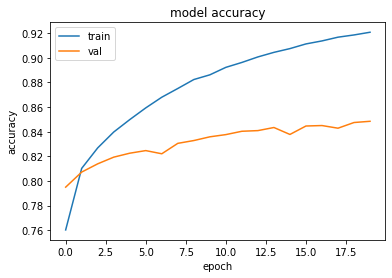

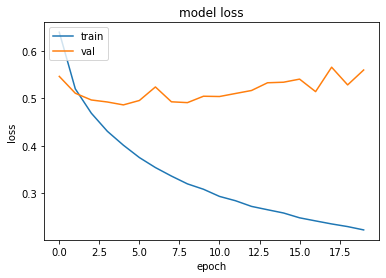

In [12]:
# Performance and evaluation
# Accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

Accuracy: 0.8496194198724543
Cohen's Kappa: 0.6813529701303398
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     13428
           1       0.56      0.38      0.45      4793
           2       0.88      0.94      0.91     35250

    accuracy                           0.85     53471
   macro avg       0.76      0.70      0.72     53471
weighted avg       0.84      0.85      0.84     53471



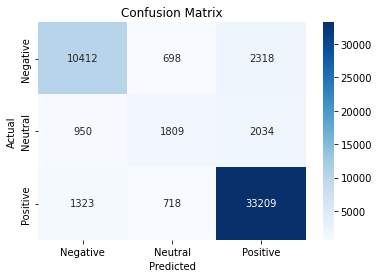

In [13]:
# Evaluate the model on the test data
y_pred = np.argmax(model.predict(test_data), axis = -1)
y_labels = np.argmax(test_labels, axis = 1)

acc = accuracy_score(y_labels, y_pred)
kappa = cohen_kappa_score(y_labels, y_pred)
conf_matrix = confusion_matrix(y_labels, y_pred)
cr = classification_report(y_labels, y_pred)

# Print the evaluation metrics
print("Accuracy:", acc)
print("Cohen's Kappa:", kappa)
print("Classification Report:")
print(cr)

# Create heatmap of the confusion matrix
ax = plt.subplot()
sns.heatmap(conf_matrix, annot = True, fmt = 'g', ax = ax, cmap = 'Blues');

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

In [14]:
from tensorflow.keras.models import load_model
import pickle
model_path = 'lstm_model.h5'
model = load_model(model_path)
with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

def sentiment_analysis(review):
    
    
    tokenizer_sequence = tokenizer.texts_to_sequences([review])
    # pad the sequence
    sequence = pad_sequences(tokenizer_sequence, maxlen=100)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    #int2label = {(1,2,3,4,5): "Negative", 5:"neutral", (6,7,8,9,10): "Positive"}
    #result=int2label[np.argmax(prediction)]
    #print("res=",np.argmax(prediction))
    
    res=np.argmax(prediction)
    
    
    if res==0:
        return "Negative"
    elif res==1:
        return "Neutral"  
    elif res==2:
        return "Positive"
    

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
# lets find the Highest and Lowest Rated Drugs for each Condition
import pandas as pd

data = pd.read_csv("drugsComTrain_raw.csv", sep=',')


In [16]:
from ipywidgets import interact

@interact
def high_low_rate(condition=list(['Select a condition'] + data['condition'].value_counts().index.tolist())):
#def high_low_rate(condition=list(['Select a condition'] + data['condition'].value_counts().index.tolist())):
    if condition == 'Select a condition':
        #print("Please select a valid condition.")
        return

    # Print the selected condition
    print(f"Selected condition: {condition}")
    
    sentiment_list = []
   
    data2 = data[data['condition'] == condition][['drugName','review']]
    drug = data2["drugName"]
    review = data2["review"]
     
    drug_list = drug.tolist()
    review_list = review.tolist()
    
    #print("drug_list",len(drug_list))
    #print(len(review_list))
    
    
    for review in review_list:
        res = sentiment_analysis(review)
        #print("result",res)
        sentiment_list.append(res)
    
    drug_rec = set()
    for i,sentiment in enumerate(sentiment_list):
        if sentiment=="Positive":
            drug_rec.add(drug_list[i])
    print("Recommended Drugs:")
    print("-"*20)
    
    
    for drug in list(drug_rec)[0:5]:
        print(drug)
        
        
        
    
    

# Run the interactive widget
#high_low_rate()


interactive(children=(Dropdown(description='condition', options=('Select a condition', 'Birth Control', 'Depre…